In [3]:
# Install packages

import requests
from bs4 import BeautifulSoup
import lxml
import lxml.etree
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import arrow

In [4]:
# Gather links with relevant lists

link_before_20 = "https://en.wikipedia.org/wiki/List_of_female_scientists_before_the_20th_century"
link_in_20 = "https://en.wikipedia.org/wiki/List_of_female_scientists_in_the_20th_century"
link_in_21 = "https://en.wikipedia.org/wiki/List_of_female_scientists_in_the_21st_century"

In [5]:
def get_names(link):
    
    url = requests.get(link).text
    soup = BeautifulSoup(url, "html.parser")
    link_list = re.findall(r"<li><a.*<\/li>", str(soup))
    df = pd.DataFrame(columns=["Name", "Link", "Birthday", "Deathday"])
    
    print("Found", len(link_list), "potential hits.")
    
    i = 0
    for link in link_list:
        
        try:
            
            name = re.findall(r"title=\"(.*?)\">", str(link))
            link = re.findall(r"href=\"(.*?)\"", str(link))
            df.loc[i] = [name[0], link[0], "", ""]
            i += 1
            
        except:
            
            pass
        
    return(df)

def get_bday(link):
    
    try:
    
        url = requests.get(link).text
        soup = BeautifulSoup(url, "html.parser")
    
        try:
        
            bio_table = re.findall(r"<table class=\"infobox biography vcard\".*?<\/tbody><\/table>", str(soup)) 
            birthday = re.findall(r"<span class=\"bday\">(.*?)<\/span>", str(bio_table[0]))
        
            if len(birthday) == 1:
            
                return(birthday)
        
            else: 
        
                return("Not found")
        
        except:
        
            return("Not found")
        
    except:
        
        return("Not found")
    
def get_dday(link):
    
    try:
    
        url = requests.get(link).text
        soup = BeautifulSoup(url, "html.parser")
    
        try:
        
            bio_table = re.findall(r"<table class=\"infobox biography vcard\".*?<\/tbody><\/table>", str(soup)) 
            deathday = re.findall(r"Died</th><td>.*?<span style=\"display:none\">\((.*?)\)<\/span>", str(bio_table[0]))
        
            if len(deathday) == 1:
            
                return(deathday)
        
            else: 
        
                return("Not found")
    
        except:
        
            return("Not found")
        
    except:
        
        return("Not found")
    
def add_bio_to_df(df):
    
    for i, row in df.iterrows():
        
        df.loc[i, "Birthday"] = get_bday("https://en.wikipedia.org"+df.loc[i][1])
        df.loc[i, "Deathday"] = get_dday("https://en.wikipedia.org"+df.loc[i][1])
        
    return(df)

def check_data(df):
    
    df = df[((df.Birthday != "Not found") |
             (df.Deathday != "Not found"))]
    
    df = df[df.Name != "Category:21st-century women scientists"]
    
    df
    
    return(df)

def extract_bdays(df):
    
    bday_list = []
    
    for i, row in df.iterrows():
        
        bday = df.loc[i, "Birthday"]
        
        if bday != "Not found":
            
            bday_list.append(bday[0])
            
    return(bday_list)

def extract_ddays(df):
    
    dday_list = []
    
    for i, row in df.iterrows():
        
        dday = df.loc[i, "Deathday"]
        
        if dday != "Not found":
            
            dday_list.append(dday[0])
            
    return(dday_list)

def complete_links(df):
    
    for i, row in df.iterrows():
        
        df.loc[i, "Link"] = "https://en.wikipedia.org" + df.loc[i, "Link"]
        
    return(df)

def prepare_for_google_calendar(df):
    """
    According to: https://support.google.com/calendar/answer/37118?hl=en
    """
    
    csv_df = pd.DataFrame(columns=["Subject", "Start date", "All Day Event", "Description"])
    
    j = 0 
    
    for i, row in df.iterrows():
        
        bday = df.loc[i, "Birthday"]
        dday = df.loc[i, "Deathday"]
        
        if bday != "Not found":
            
            csv_df.loc[j] = [df.loc[i, "Name"] + " was born.", 
                         arrow.get(bday[0]).format("MM/DD/YYYY"),
                         "true", 
                         "https://en.wikipedia.org" + df.loc[i, "Link"]]
            j += 1
        
        if dday != "Not found":
            
            csv_df.loc[j] = [df.loc[i, "Name"] + " died.", 
                         arrow.get(dday[0]).format("MM/DD/YYYY"),
                         "true", 
                         "https://en.wikipedia.org" + df.loc[i, "Link"]]
            j += 1
            
    return(csv_df)

In [6]:
df_before_20 = get_names(link_before_20) # Found 353 potential hits.
df_in_20 = get_names(link_in_20) # Found 497 potential hits.
df_in_21 = get_names(link_in_21) # Found 264 potential hits.

Found 353 potential hits.
Found 497 potential hits.
Found 264 potential hits.


In [10]:
df_before_20 = add_bio_to_df(df_before_20)
df_in_20 = add_bio_to_df(df_in_20)
df_in_21 = add_bio_to_df(df_in_21)

In [11]:
df_before_20 = check_data(df_before_20)
#df_before_20
df_in_20 = check_data(df_in_20)
#df_in_20
df_in_21 = check_data(df_in_21)
#df_in_21

In [108]:
# Load and prepare data for comparison from http://www.dartmouth.edu/~chance/teaching_aids/data.html

date_list = []
weight_list = []
filepath = 'birthday.txt'

with open(filepath) as fp:
    
    line = fp.readline()

    while line:
        
        if len(line) > 6:
            
            tmp = line.strip().split("\t")
            date = tmp[0]
            weight = tmp[1]
            date_list.append(datetime.strptime(date, "%m/%d/%y").isocalendar()[1])
            weight_list.append(int(weight))
            line = fp.readline()

sum(weight_list)

3333239

111

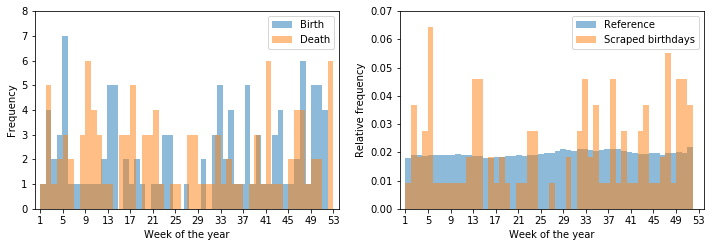

In [107]:
# Plot bday distribution

bdays_before_20 = extract_bdays(df_before_20)
bdays_in_20 = extract_bdays(df_in_20)
bdays_in_21 = extract_bdays(df_in_21)

bdays = bdays_before_20 + bdays_in_20 + bdays_in_21

ddays_before_20 = extract_ddays(df_before_20)
ddays_in_20 = extract_ddays(df_in_20)
ddays_in_21 = extract_ddays(df_in_21)

ddays = ddays_before_20 + ddays_in_20 + ddays_in_21

all_days = bdays + ddays

hist_list_all = []

for date in all_days:
    
    hist_list_all.append(datetime.strptime(date, "%Y-%m-%d").isocalendar()[1])

hist_list_bday = []

for date in bdays:
    
    hist_list_bday.append(datetime.strptime(date, "%Y-%m-%d").isocalendar()[1])

hist_list_dday = []

for date in ddays:
    
    hist_list_dday.append(datetime.strptime(date, "%Y-%m-%d").isocalendar()[1])
    
num_bins = 52
plt.figure(figsize=(12, 8))
plt.subplot(221)
n, bins, patches = plt.hist(hist_list_bday, num_bins, alpha=0.5, label = "Birth")
n, bins, patches = plt.hist(hist_list_dday, num_bins, alpha=0.5, label = "Death")
plt.xlabel('Week of the year')
plt.ylabel('Frequency')
plt.axis([0, 54, 0, 8])
plt.legend(loc='upper right')
plt.xticks(np.arange(1, 55, 4))

plt.subplot(222)
plt.hist(date_list, num_bins, weights=weight_list, density=True, alpha=0.5, label = "Reference")
n, bins, patches = plt.hist(hist_list_bday, num_bins, alpha=0.5, label = "Scraped birthdays", density=True)
plt.xlabel('Week of the year')
plt.ylabel('Relative frequency')
plt.axis([0, 54, 0, 0.07])
plt.legend(loc='upper right')
plt.xticks(np.arange(1, 55, 4))
plt.savefig("histogram.png", bbox_inches="tight", dpi = 300)
#plt.show()




In [363]:
# Prepare csv for excel

df_all_scientists = pd.concat([df_before_20, df_in_20, df_in_21]).reset_index()

df_all_scientists = prepare_for_google_calendar(df_all_scientists)

df_all_scientists.to_csv(r"./list_for_google_import.csv", index = False)

df_all_scientists

,Subject,Start date,All Day Event,Description
0,Maria Sibylla Merian was born.,04/02/1647,true,https://en.wikipedia.org/wiki/Maria_Sibylla_Me...
1,Maria Sibylla Merian died.,01/13/1717,true,https://en.wikipedia.org/wiki/Maria_Sibylla_Me...
2,Jacoba van den Brande died.,08/14/1794,true,https://en.wikipedia.org/wiki/Jacoba_van_den_B...
3,Jane Colden was born.,03/27/1724,true,https://en.wikipedia.org/wiki/Jane_Colden
4,Jane Colden died.,03/10/1766,true,https://en.wikipedia.org/wiki/Jane_Colden
...,...,...,...,...
213,Helena Hamerow was born.,09/18/1961,true,https://en.wikipedia.org/wiki/Helena_Hamerow
214,Alice Alldredge was born.,02/01/1949,true,https://en.wikipedia.org/wiki/Alice_Alldredge
215,Pamela Gay was born.,12/12/1973,true,https://en.wikipedia.org/wiki/Pamela_Gay
216,Ann Kiessling was born.,03/29/1942,true,https://en.wikipedia.org/wiki/Ann_Kiessling
